### Building a Model To predict Emails Clic Through Rates (CTR%) , Based on the following Features 
- Time ( month of the year , quarter of the year , day of the week )
- Pirority of email , main or reminder 
- Category ( interval , final )
- Number of emails sent in each subject
- Constructed Features
 - Length of the subject 
 - Personalization of Email
 - Having emoji or not
 - Casual tone or formal 
 - Urgency at the subject 
 - Metion of price or discount in the subject 
 - Imperative tone in the subject 
 - Mention of product in the subject

In [1]:
#importing libraries 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# reading data as a dataframe 
df = pd.read_csv("model_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sent date            1279 non-null   object 
 1   Q                    1279 non-null   object 
 2   DD                   1279 non-null   object 
 3   Category name        1279 non-null   object 
 4   Main vs REM          1279 non-null   object 
 5   Subject              1279 non-null   object 
 6   Sendings             1279 non-null   int64  
 7   OR clean %           1279 non-null   float64
 8   CTR clean %          1279 non-null   float64
 9   Date                 1279 non-null   object 
 10  Month                1279 non-null   int64  
 11  translation          1279 non-null   object 
 12  length of subject    1279 non-null   int64  
 13  Personalization      1279 non-null   int64  
 14  Emoji                1279 non-null   int64  
 15  Urgency              1279 non-null   i

In [4]:
columns_to_drop = [ "Subject", "OR clean %","translation","Sent date","Date"]  
df = df.drop(columns=columns_to_drop, errors='ignore')

- I droped  ( "Subject", " Translation") because each  is a sentence has no predictive value in this model 
- I droped  ("OR %") because it will have an affect of data leakage 
- I droped ("Date") because I already has features for ("Month"),("DD")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Q                    1279 non-null   object 
 1   DD                   1279 non-null   object 
 2   Category name        1279 non-null   object 
 3   Main vs REM          1279 non-null   object 
 4   Sendings             1279 non-null   int64  
 5   CTR clean %          1279 non-null   float64
 6   Month                1279 non-null   int64  
 7   length of subject    1279 non-null   int64  
 8   Personalization      1279 non-null   int64  
 9   Emoji                1279 non-null   int64  
 10  Urgency              1279 non-null   int64  
 11  Tone                 1279 non-null   int64  
 12  price or discount    1279 non-null   int64  
 13  imperative           1279 non-null   int64  
 14  product              1279 non-null   int64  
dtypes: float64(1), int64(10), object(4)
me

- Confirming that Data is valid for regression models 
 - Cheking correlation 
 - Ckeking multicoliniarity

In [6]:
# checking correllation 
target =  "CTR clean %"
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_with_target = numeric_df.corr()[target].sort_values(ascending=False)

print("\n✅ Correlation with target:")
print(corr_with_target)


✅ Correlation with target:
CTR clean %            1.000000
Personalization        0.214990
imperative             0.149997
Month                  0.147119
Emoji                  0.140739
Tone                   0.094586
price or discount      0.087117
length of subject      0.051266
Urgency                0.035813
product               -0.082506
Sendings              -0.399022
Name: CTR clean %, dtype: float64


In [7]:
# checking multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = numeric_df.drop(columns=[target])  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n✅ VIF to detect multicollinearity:")
print(vif_data)


✅ VIF to detect multicollinearity:
               feature       VIF
0             Sendings  1.505533
1                Month  4.814058
2    length of subject  1.295845
3      Personalization  1.785239
4                Emoji  3.151370
5              Urgency  2.004699
6                 Tone  4.946597
7  price or discount    4.673142
8          imperative   2.889202
9              product  3.947160


Building first simple linear regression model

In [8]:
# building X ( feaures ) , y (target)
target_column = "CTR clean %" 
X = df.drop(columns=[target_column])
y = df[target_column]

In [9]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [10]:
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

In [12]:
#spliting the data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

In [14]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Q', 'DD', 'Category name',
                                                   'Main vs REM'])])),
                ('regressor', LinearRegression())])

In [15]:
y_pred = model.predict(X_test)

In [16]:
print("✅ Model Performance:")
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

✅ Model Performance:
R² Score: 0.23869839700843087
MSE: 0.0008064112794209036


The previous linear regression model predictive power is very weak , so i will build another tree model 

--------------------------------------------------------------------------------------------------------

Building a RandomForestRegressor Model 

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

model2 = model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R² Score: 0.4273528911320279
MSE: 0.0006065783730183696


Next I will improve the previous model , by searching in different hyperparameter space 

In [18]:
X = pd.get_dummies(X, drop_first=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [ 200,400],       
    'max_depth': [ 10, 20 ,None],       
    'min_samples_split': [ 5,8],      
    'min_samples_leaf': [1],       
    'max_features': [ 0.8]     
}


grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid,
    cv=3, n_jobs=-1, scoring='r2'
)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predict
y_pred = best_rf.predict(X_test)

# Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("\n✅ Best Hyperparameters Found:")
print(grid_search.best_params_)

R² Score: 0.5140835820645242
MSE: 0.0005147085974063146

✅ Best Hyperparameters Found:
{'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 400}


Creating a Chart for the most important features in the Dataset

                      feature  importance
0                    Sendings    0.643423
1                       Month    0.083198
19  Category name_NL Interval    0.068471
18               DD_Wednesday    0.025191
15                  DD_Sunday    0.022893


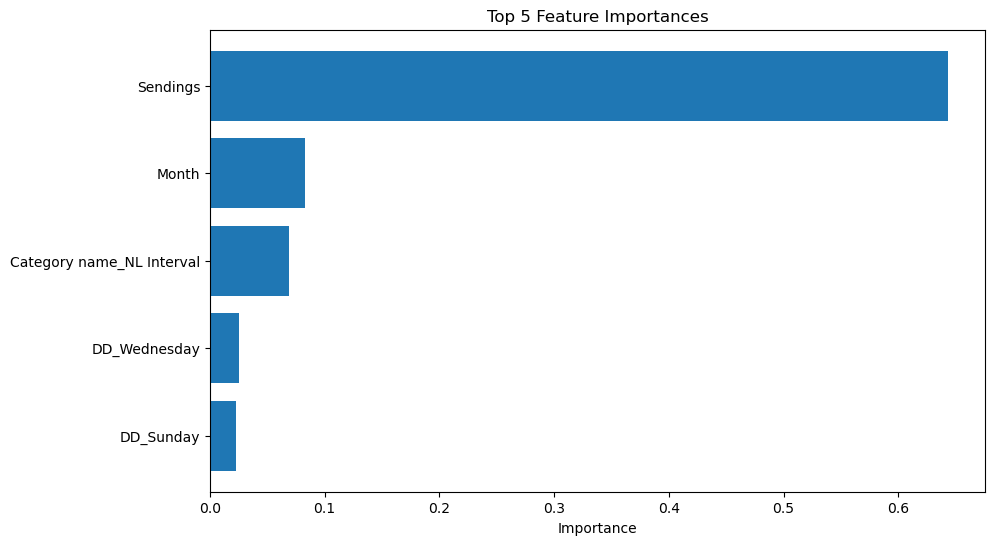

In [21]:

import matplotlib.pyplot as plt

# Assuming `best_rf` is your trained RandomForestRegressor
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances.head(5))

# Optional: Plot
top5_features = feature_importances.head(5)

# Plot
plt.figure(figsize=(10,6))
plt.barh(top5_features['feature'], top5_features['importance'])
plt.xlabel("Importance")
plt.title("Top 5 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

### Future improvment 
- I believe that having more data ( actual content of Emails/data about receivers of mails) is essential to create more effective CTR% predictive model, because predicting CTR% depending on many other factors
- By testing more complicated models ( logistic regression / neuron network ), could result in finding a better model in terms of predictions 
- trying more hyperparameters will result in finding a better model , but this step need more computational power 
